# Train du modèle

Ici nous allons entraîner notre modèle général. Ce modèle est entrainé sur l'ensemble des voitures.

### Importation des bibliothèques

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
from torchvision import datasets, transforms
from torchvision.transforms import autoaugment
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import seaborn as sns
import os
from tqdm import tqdm
import shutil
import time
import networkx as nx

### Setup du device pour entrainement sur gpu

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Récupération des données et préparation du dataset

### Concaténation des données afin de créer un dataset général

In [22]:
if not os.path.exists("../dataset/car_data/car_data/final/full"):
    os.makedirs("../dataset/car_data/car_data/final/full")

class_folders_train = os.listdir("../dataset/car_data/car_data/train")
class_folders_test = os.listdir("../dataset/car_data/car_data/test")
for class_folder in class_folders_train:
    if not os.path.exists(f"../dataset/car_data/car_data/final/full/{class_folder}"):
        os.makedirs(f"../dataset/car_data/car_data/final/full/{class_folder}")
    for image in os.listdir(f"../dataset/car_data/car_data/train/{class_folder}"):
        img_name = image.split(".")
        img_name[0] = img_name[0] + "_train"
        image_train = ".".join(img_name)
        shutil.copy(f"../dataset/car_data/car_data/train/{class_folder}/{image}", f"../dataset/car_data/car_data/final/full/{class_folder}/{image_train}")
for class_folder in class_folders_test:
    if not os.path.exists(f"../dataset/car_data/car_data/final/full/{class_folder}"):
        os.makedirs(f"../dataset/car_data/car_data/final/full/{class_folder}")
    for image in os.listdir(f"../dataset/car_data/car_data/test/{class_folder}"):
        img_name = image.split(".")
        img_name[0] = img_name[0] + "_test"
        image_test = ".".join(img_name)
        shutil.copy(f"../dataset/car_data/car_data/test/{class_folder}/{image}", f"../dataset/car_data/car_data/final/full/{class_folder}/{image_test}")

### Création du dataset avec le bonne taille de train/test set

In [23]:
train_size = 0.8
test_size = 1 - train_size

if not os.path.exists("../dataset/car_data/car_data/final/train"):
    os.makedirs("../dataset/car_data/car_data/final/train")
if not os.path.exists("../dataset/car_data/car_data/final/test"):
    os.makedirs("../dataset/car_data/car_data/final/test")

# Take train_size of the data for training and test_size for testing
for class_folder in class_folders_train:
    if not os.path.exists(f"../dataset/car_data/car_data/final/train/{class_folder}"):
        os.makedirs(f"../dataset/car_data/car_data/final/train/{class_folder}")
    if not os.path.exists(f"../dataset/car_data/car_data/final/test/{class_folder}"):
        os.makedirs(f"../dataset/car_data/car_data/final/test/{class_folder}")
    images = os.listdir(f"../dataset/car_data/car_data/final/full/{class_folder}")
    train_images = images[:int(len(images)*train_size)]
    test_images = images[int(len(images)*train_size):]
    for image in train_images:
        shutil.copy(f"../dataset/car_data/car_data/final/full/{class_folder}/{image}", f"../dataset/car_data/car_data/final/train/{class_folder}/{image}")
    for image in test_images:
        shutil.copy(f"../dataset/car_data/car_data/final/full/{class_folder}/{image}", f"../dataset/car_data/car_data/final/test/{class_folder}/{image}")

### Récupération des labels du dataset

In [24]:
df_names = pd.read_csv('../dataset/names.csv', names=['name'])

### Définition des hyperparamètres

In [25]:
batch_size = 32
epochs = 1

### Définition des transformations appliquées sur les données

In [26]:
train_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Création du jeu de donnée

In [27]:
#Chargement des images dans des datasets
path_test = '../dataset/car_data/car_data/final/test'
path_train = '../dataset/car_data/car_data/final/train'

train_dataset = datasets.ImageFolder(root=path_train, transform = train_tfms)

test_dataset = datasets.ImageFolder(root=path_test, transform = test_tfms)

print(f'Train dataset size is {len(train_dataset)}')
print(f'Test dataset size is {len(test_dataset)}')

Train dataset size is 12873
Test dataset size is 3312


In [28]:
#Convertion des datasets en dataLoader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers = 2)

### Chargement du modèle

In [29]:
no_classes = len(train_dataset.classes) # Nombre de classes
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Changememt du dernier layer pour l'adapté à notre problématique

In [30]:
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# Définition de la fonction de Loss et de l'optimisation
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

### Définition des fonctions de train et d'évaluation

In [31]:
def eval_model(model, test_loader, device, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader), 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    test_acc = 100.0 * correct / total
    print('Accuracy sur le dataset de test: %d %%' % (
        test_acc))
    return test_acc

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        
        for i, data in enumerate(tqdm(train_loader), 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==preds).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Fin entraînement')
    return model, losses, accuracies, test_accuracies

### Entrainement du modèle

In [32]:
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=epochs)

100%|██████████| 403/403 [10:27<00:00,  1.56s/it]


Epoch 1, duration: 627 s, loss: 3.8880, acc: 18.4553


100%|██████████| 104/104 [00:24<00:00,  4.21it/s]

Accuracy sur le dataset de test: 44 %
Fin entraînement


### Affichage des résultats de l'entrainement

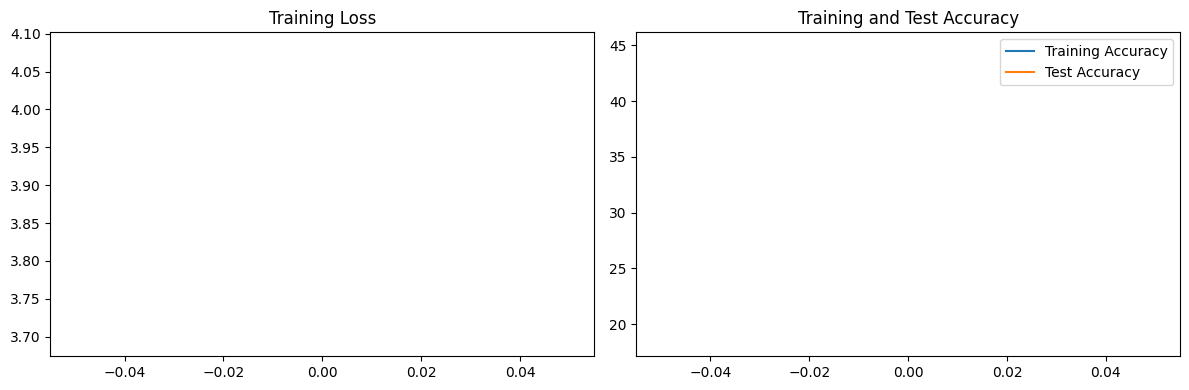

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

### Sauvegarde du modèle

In [34]:
torch.save(model.state_dict(), 'model.pth')

### Évaluation du modèle

Text(0.5, 80.7222222222222, 'Predicted label')

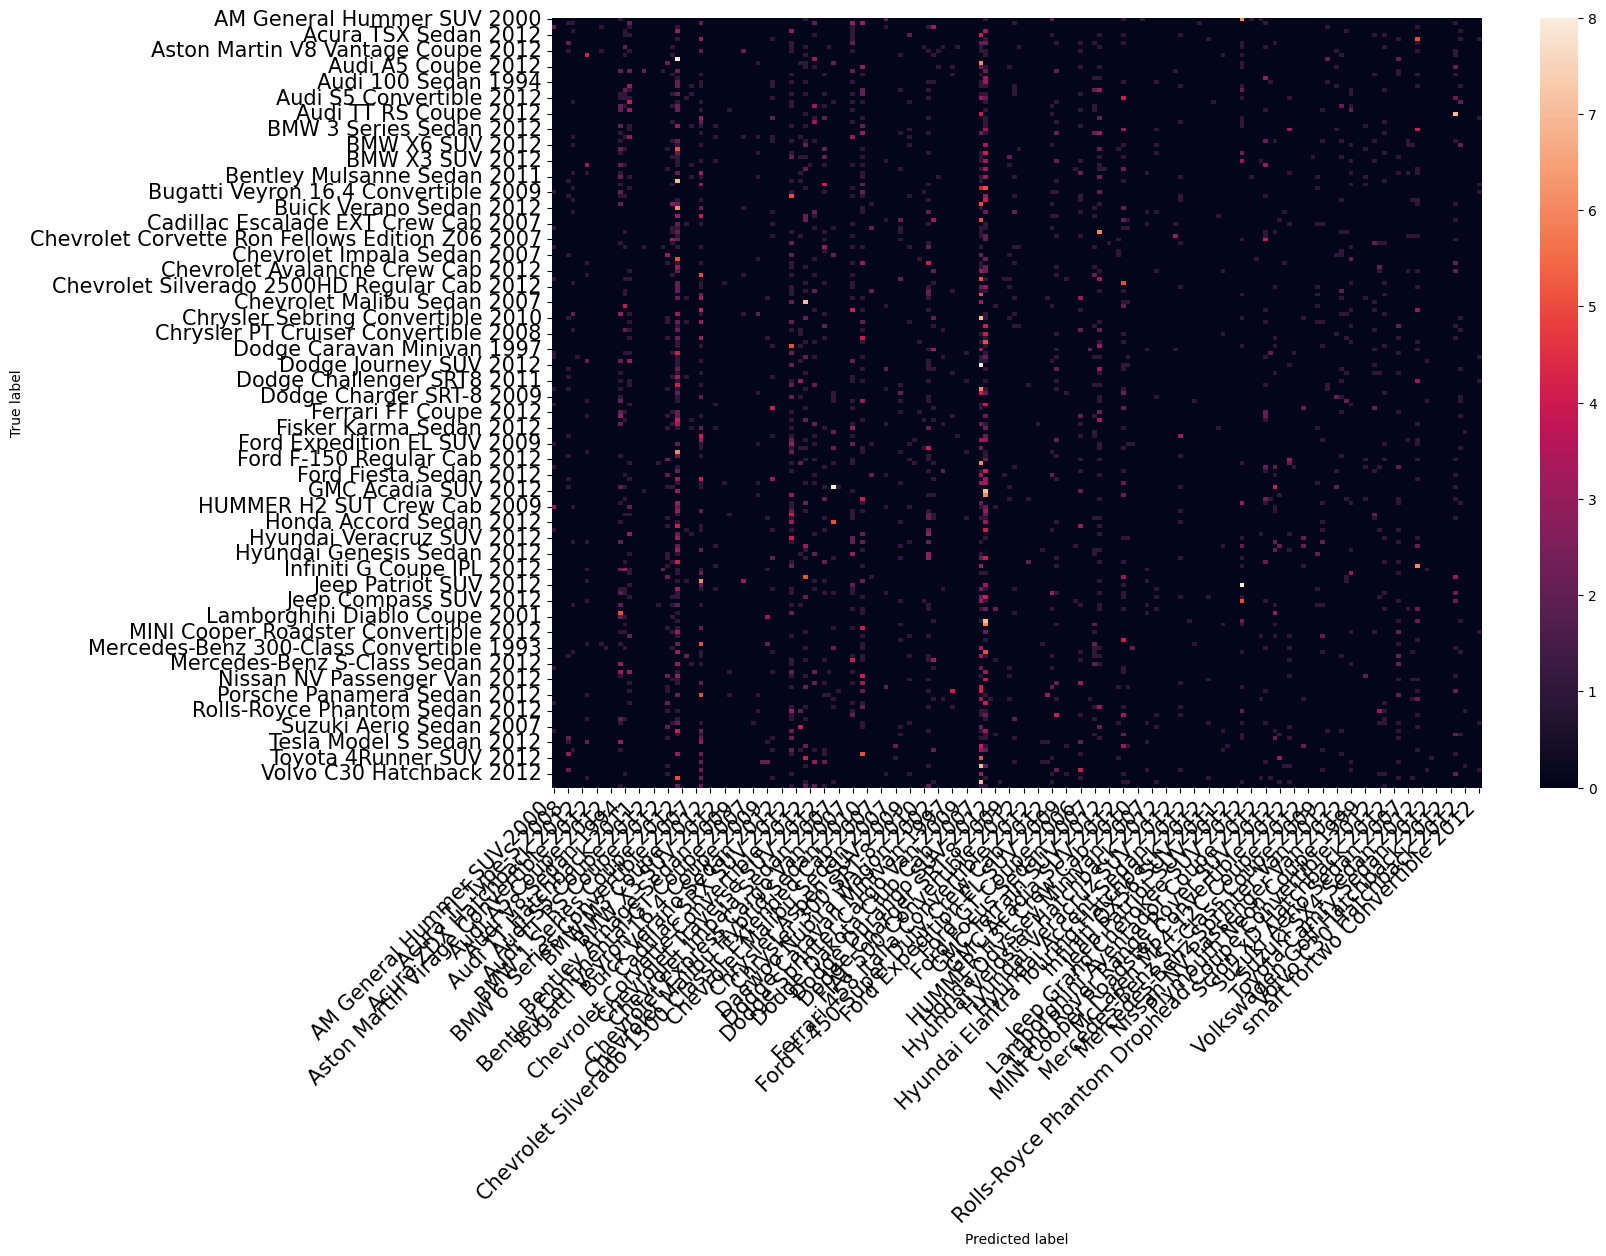

In [35]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(15,10))

class_names = list(df_names['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
#Set the diagonal to zero, so we can see the other values better
for i in range(len(df_cm)):
    df_cm.iat[i, i] = 0
heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Visualisation des résultats du modèle

In [36]:
dir = "../dataset/names.csv"
classes = np.genfromtxt(dir, delimiter=',', dtype=str)

In [39]:
cm_copy = cm.copy()
cm_copy[cm_copy < 3] = 0
G = nx.from_numpy_array(cm_copy)
composantes_connexes = list(nx.connected_components(G))
composantes_connexes = [[e for e in s] for s in composantes_connexes]

In [40]:
sub_cms = [
    cm[sub,:][:,sub]
    for sub in composantes_connexes
]
sub_classes = [
    classes[sub]
    for sub in composantes_connexes
]

In [41]:
def show_cm(cm, classes, diag_zero = False, ax=None, show=True, rotation=None):
    cm_copy = cm.copy()
    if diag_zero:
        np.fill_diagonal(cm_copy, 0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_copy, display_labels=classes)

    disp.plot(ax=ax)
    
    if rotation:
        plt.xticks(rotation=rotation)
    if show:
        plt.show()

def show_cm_with_without_diag(cm, clases):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    show_cm(cm, classes, ax=axes[0], show=False)
    show_cm(cm, classes, diag_zero=True, ax=axes[1])

nb classes : 1


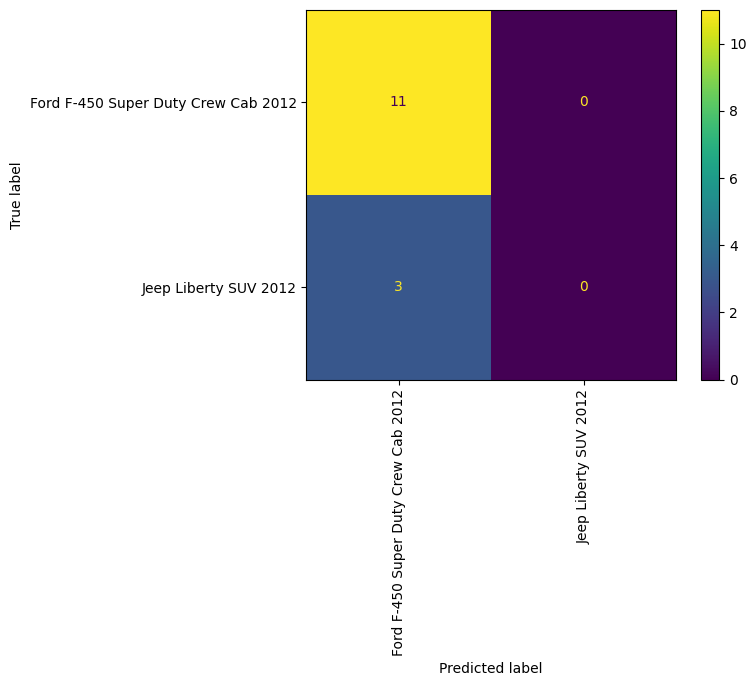

In [42]:
# drop the too big cms
sub_cms, sub_classes = list(zip(*[
    (sub_cm, sub_classes)
    for sub_cm, sub_classes in zip(sub_cms, sub_classes)
    if 1 < sub_cm.shape[0] < 15
]))

print("nb classes :", len(sub_classes))

n_per_line = 1
nrows = math.ceil(len(sub_classes) / n_per_line)
    
if False:
    fig, axes = plt.subplots(nrows=nrows, ncols=n_per_line, figsize=(11, 5 * nrows))
    if len(axes.shape) == 1:
        axes = axes.reshape((nrows, n_per_line))

for sub_cm, sub_class, i in zip(sub_cms, sub_classes, range(len(sub_cms))):
    show_cm(sub_cm, sub_class, diag_zero=False, rotation=90)